# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [186]:
import sys
# sys.path.append('..')

from pathlib import Path

import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import evaluation.clemmetrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [187]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [188]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,9.0
2,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Request Count,9.0
3,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Ins...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
57682,adventuregame,Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-...,7_home_deliver_three_planning_hard_invlimittwo,episode_5,Played,1.0
57683,adventuregame,Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-...,7_home_deliver_three_planning_hard_invlimittwo,episode_6,Played,1.0
57684,adventuregame,Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-...,7_home_deliver_three_planning_hard_invlimittwo,episode_7,Played,1.0
57685,adventuregame,Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-...,7_home_deliver_three_planning_hard_invlimittwo,episode_8,Played,0.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [189]:
model_name_dict = {
    'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0': 'openchat3.5-GGUF-q8',
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B-Instruct",
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0': 'Llama-3.1-8B-Instruct',
    'Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B-Instruct-t0.0': 'Llama-3-8B-Instruct',
    'Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-t0.0': 'Qwen2.5-7B-Instruct',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0': 'Qwen2.5-Coder-32B-Instruct',
    'Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-7B-Instruct-t0.0': 'Qwen2.5-Coder-7B-Instruct',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0': 'Qwen2.5-72B-Instruct',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0': 'Llama-3.3-70B-Instruct',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0': 'Meta-Llama-3.1-70B-Instruct'
}

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_easy_invlimittwo': "basic-easy-invlimit",
    '3_home_deliver_three_planning_easy_invlimittwo': "planning-easy-invlimit",
    '4_home_deliver_three_basic_hard': "basic-hard",
    '5_home_deliver_three_planning_hard': "planning-hard",
    '6_home_deliver_three_basic_hard_invlimittwo': "basic-hard-invlimit",
    '7_home_deliver_three_planning_hard_invlimittwo': "planning-hard-invlimit"
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed",
    'domain_trait_type_mismatch': "domain mismatch",
    'domain_type_discrepancy': "domain discrepancy",
    'world_state_discrepancy': "world state discrepancy",
    'entity_state_mismatch': "entity state mismatch",
    'entity_trait_mismatch': "entity trait mismatch",
    'inventory_limit_exceeded': "inventory limit exceeded"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [190]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Parsed Request Count,9.0
2,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Count,9.0
3,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
57682,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_5,Played,1.0
57683,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_6,Played,1.0
57684,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_7,Played,1.0
57685,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_8,Played,0.0


## Overall benchmark scores

In [191]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [192]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Llama-3.3-70B-Instruct,65.62,97.66,67.19,39.68,97.66,67.19
Llama-3-8B-Instruct,10.16,60.94,16.67,27.43,60.94,16.67
Meta-Llama-3.1-70B-Instruct,65.35,100.00,65.35,41.02,100.00,65.35
Llama-3.1-8B-Instruct,36.11,97.66,36.98,40.17,97.66,36.98
Qwen2-72B-Instruct,42.85,91.41,46.88,41.50,91.41,46.88
Qwen2.5-72B-Instruct,45.05,96.09,46.88,41.92,96.09,46.88
Qwen2.5-7B-Instruct,10.62,90.62,11.72,21.97,90.62,11.72
Qwen2.5-Coder-32B-Instruct,55.44,97.66,56.77,37.03,97.66,56.77
Qwen2.5-Coder-7B-Instruct,2.07,88.28,2.34,11.21,88.28,2.34
openchat3.5-GGUF-q8,10.26,93.75,10.94,23.70,93.75,10.94


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [193]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score,Quality Score (std)
Llama-3.3-70B-Instruct,65.62,97.66,67.19,39.68
Meta-Llama-3.1-70B-Instruct,65.35,100.00,65.35,41.02
Qwen2.5-Coder-32B-Instruct,55.44,97.66,56.77,37.03
Qwen2.5-72B-Instruct,45.05,96.09,46.88,41.92
Qwen2-72B-Instruct,42.85,91.41,46.88,41.50
Llama-3.1-8B-Instruct,36.11,97.66,36.98,40.17
openchat3.5,12.61,91.41,13.80,28.53
Qwen2.5-7B-Instruct,10.62,90.62,11.72,21.97
openchat3.5-GGUF-q8,10.26,93.75,10.94,23.70
Llama-3-8B-Instruct,10.16,60.94,16.67,27.43


In [194]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [195]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=2).format(subset="% Played", precision=2).format(subset="Quality Score", precision=2).format(subset="Quality Score (std)", precision=2)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

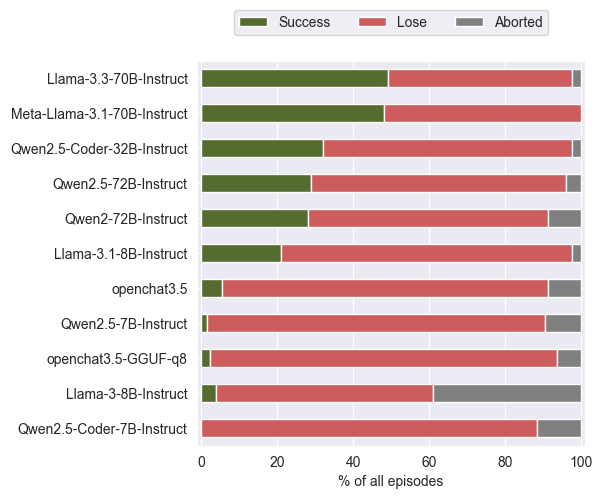

In [196]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]
df_aux = df_aux.replace(model_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with sorted clemscores:

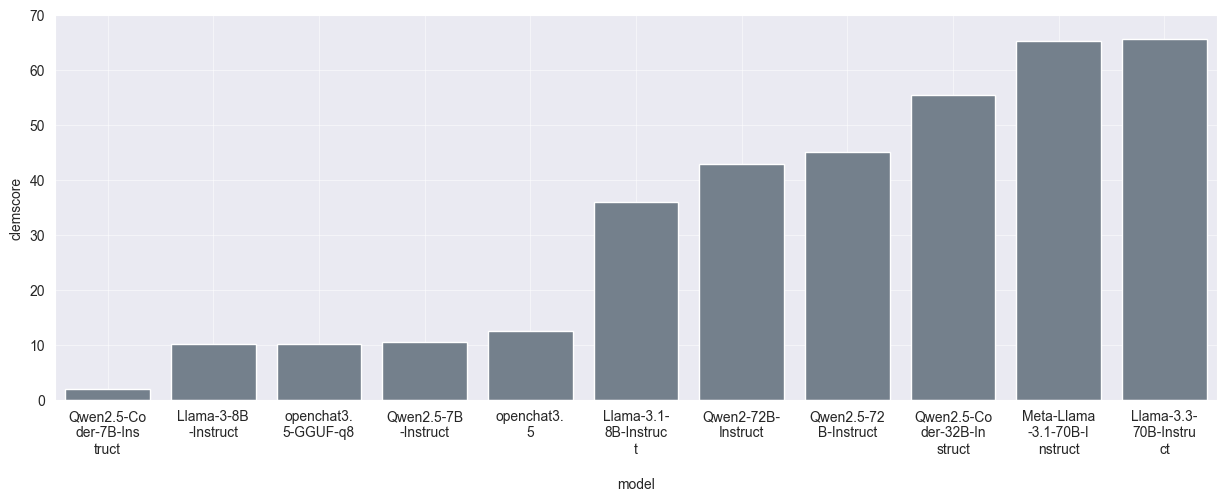

In [247]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 70)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [198]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Parsed Request Count,9.0
2,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Count,9.0
3,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
57682,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_5,Played,1.0
57683,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_6,Played,1.0
57684,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_7,Played,1.0
57685,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_8,Played,0.0


## Failure metrics
### Failures by IF interpreter phase

In [199]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,action_resolution_fail,0.0
45,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_1,action_parsing_fail,0.0
46,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_1,action_resolution_fail,1.0
85,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
56166,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_7,action_resolution_fail,0.0
56205,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_8,action_parsing_fail,9.0
56206,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_8,action_resolution_fail,4.0
56245,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_9,action_parsing_fail,0.0


Bar plot showing failures by phase for all models over all experiments:

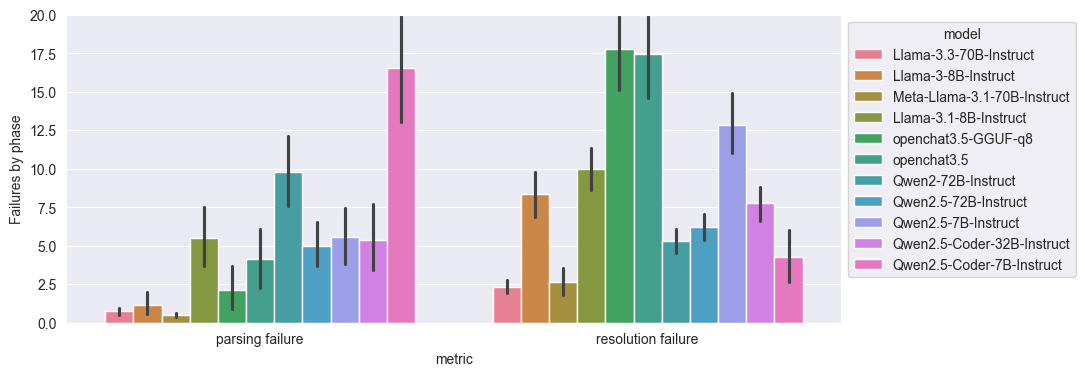

In [200]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 20)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [201]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Llama-3-8B-Instruct,3041.0
Llama-3.1-8B-Instruct,4800.0
Llama-3.3-70B-Instruct,2868.0
Meta-Llama-3.1-70B-Instruct,2942.0
Qwen2-72B-Instruct,4535.0
Qwen2.5-72B-Instruct,4219.0
Qwen2.5-7B-Instruct,5569.0
Qwen2.5-Coder-32B-Instruct,4693.0
Qwen2.5-Coder-7B-Instruct,5585.0


Counts of failures by phase for all models over all experiments:

In [202]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model                       metric                    
Llama-3-8B-Instruct         parsing failure      146.0
                            resolution failure  1067.0
Llama-3.1-8B-Instruct       parsing failure      704.0
                            resolution failure  1276.0
Llama-3.3-70B-Instruct      parsing failure       94.0
                            resolution failure   297.0
Meta-Llama-3.1-70B-Instruct parsing failure       63.0
                            resolution failure   334.0
Qwen2-72B-Instruct          parsing failure     1249.0
                            resolution failure   680.0
Qwen2.5-72B-Instruct        parsing failure      641.0
                            resolution failure   796.0
Qwen2.5-7B-Instruct         parsing failure      710.0
                            resolution failure  1647.0
Qwen2.5-Coder-32B-Instruct  parsing failure      689.0
                            resolution failure   991.0
Qwen2.5-Coder-7B-Instruct   parsing failure     2121.0
                            resolution failure   544.0
openchat3.5                 parsing failure      526.0
                            resolution failure  2231.0
openchat3.5-GGUF-q8         parsing failure      276.0
                            resolution failure  2275.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [203]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model                       metric                      
Llama-3-8B-Instruct         parsing failure     0.048011
                            resolution failure  0.350871
Llama-3.1-8B-Instruct       parsing failure     0.146667
                            resolution failure  0.265833
Llama-3.3-70B-Instruct      parsing failure     0.032775
                            resolution failure  0.103556
Meta-Llama-3.1-70B-Instruct parsing failure     0.021414
                            resolution failure  0.113528
Qwen2-72B-Instruct          parsing failure     0.275413
                            resolution failure  0.149945
Qwen2.5-72B-Instruct        parsing failure     0.151932
                            resolution failure  0.188670
Qwen2.5-7B-Instruct         parsing failure     0.127491
                            resolution failure  0.295744
Qwen2.5-Coder-32B-Instruct  parsing failure     0.146814
                            resolution failure  0.211166
Qwen2.5-Coder-7B-Instruct   parsing failure     0.379767
                            resolution failure  0.097404
openchat3.5                 parsing failure     0.121366
                            resolution failure  0.514767
openchat3.5-GGUF-q8         parsing failure     0.061786
                            resolution failure  0.509290

Overview/model comparison stacked bar plot for successful actions and failures by phase:

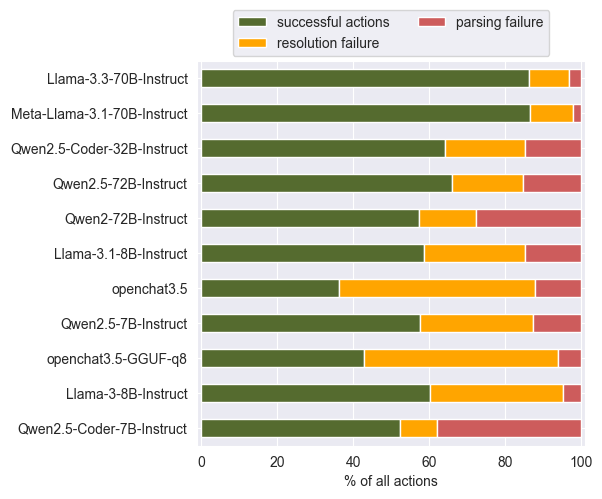

In [204]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [205]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model               metric                                
Llama-3-8B-Instruct malformed command       56.0  0.018415
                    out of grammar           1.0  0.000329
                    undefined action type    0.0  0.000000
                    undefined action verb   41.0  0.013482
                    undefined antecedent     0.0  0.000000
...                                          ...       ...
openchat3.5-GGUF-q8 out of grammar          31.0  0.006940
                    undefined action type    0.0  0.000000
                    undefined action verb   63.0  0.014103
                    undefined antecedent     0.0  0.000000
                    undefined noun          97.0  0.021715

[66 rows x 2 columns]

In [206]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

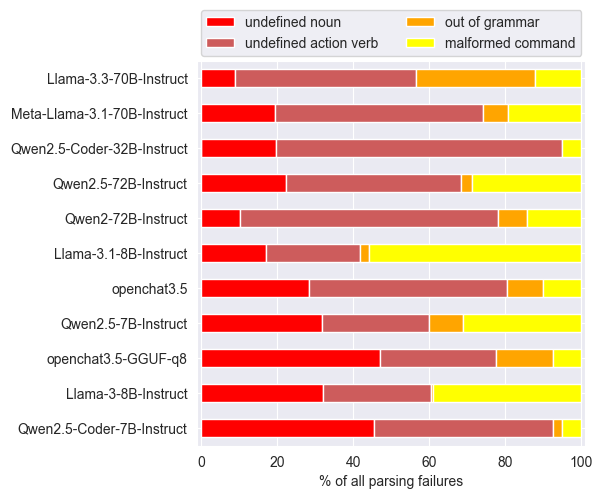

In [207]:
STACK_COLORS = ['red', 'indianred', 'orange', 'yellow']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [208]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model                       metric                                      
Llama-3-8B-Instruct         going to non-adjacent room   207.0  0.068070
                            interacting with other room    2.0  0.000658
                            manipulating room              0.0  0.000000
Llama-3.1-8B-Instruct       going to non-adjacent room   230.0  0.047917
                            interacting with other room   11.0  0.002292
                            manipulating room              0.0  0.000000
Llama-3.3-70B-Instruct      going to non-adjacent room   157.0  0.054742
                            interacting with other room    4.0  0.001395
                            manipulating room              0.0  0.000000
Meta-Llama-3.1-70B-Instruct going to non-adjacent room   144.0  0.048946
                            interacting with other room    0.0  0.000000
                            manipulating room              0.0  0.000000
Qwen2-72B-Instruct          going to non-adjacent room   306.0  0.067475
                            interacting with other room    8.0  0.001764
                            manipulating room              1.0  0.000221
Qwen2.5-72B-Instruct        going to non-adjacent room   284.0  0.067315
                            interacting with other room    9.0  0.002133
                            manipulating room              0.0  0.000000
Qwen2.5-7B-Instruct         going to non-adjacent room   346.0  0.062130
                            interacting with other room   42.0  0.007542
                            manipulating room              0.0  0.000000
Qwen2.5-Coder-32B-Instruct  going to non-adjacent room   391.0  0.083316
                            interacting with other room    0.0  0.000000
                            manipulating room              0.0  0.000000
Qwen2.5-Coder-7B-Instruct   going to non-adjacent room    27.0  0.004834
                            interacting with other room    0.0  0.000000
                            manipulating room              0.0  0.000000
openchat3.5                 going to non-adjacent room   277.0  0.063913
                            interacting with other room  101.0  0.023304
                            manipulating room             20.0  0.004615
openchat3.5-GGUF-q8         going to non-adjacent room   286.0  0.064025
                            interacting with other room   37.0  0.008283
                            manipulating room             12.0  0.002686

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

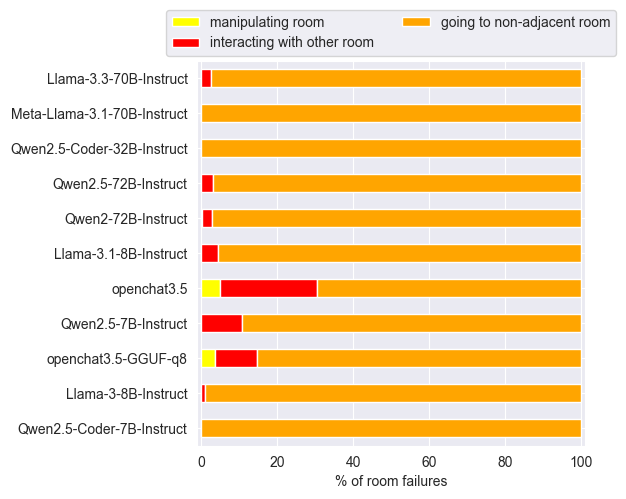

In [209]:
STACK_COLORS = ['yellow', 'orange', 'indianred', 'red', 'yellow', 'orange']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [210]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model                       metric                                       
Llama-3-8B-Instruct         entity already in inventory    12.0  0.003946
                            entity not accessible         735.0  0.241697
                            entity state mismatch           7.0  0.002302
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded       12.0  0.003946
Llama-3.1-8B-Instruct       entity already in inventory     6.0  0.001250
                            entity not accessible         668.0  0.139167
                            entity state mismatch          28.0  0.005833
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded       24.0  0.005000
Llama-3.3-70B-Instruct      entity already in inventory     7.0  0.002441
                            entity not accessible          98.0  0.034170
                            entity state mismatch           2.0  0.000697
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded       23.0  0.008020
Meta-Llama-3.1-70B-Instruct entity already in inventory     7.0  0.002379
                            entity not accessible         148.0  0.050306
                            entity state mismatch           0.0  0.000000
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded       22.0  0.007478
Qwen2-72B-Instruct          entity already in inventory    64.0  0.014112
                            entity not accessible         193.0  0.042558
                            entity state mismatch           8.0  0.001764
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded        8.0  0.001764
Qwen2.5-72B-Instruct        entity already in inventory    29.0  0.006874
                            entity not accessible         183.0  0.043375
                            entity state mismatch           5.0  0.001185
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded        5.0  0.001185
Qwen2.5-7B-Instruct         entity already in inventory    32.0  0.005746
                            entity not accessible         707.0  0.126953
                            entity state mismatch         112.0  0.020111
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded       57.0  0.010235
Qwen2.5-Coder-32B-Instruct  entity already in inventory    13.0  0.002770
                            entity not accessible         314.0  0.066908
                            entity state mismatch          15.0  0.003196
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded       16.0  0.003409
Qwen2.5-Coder-7B-Instruct   entity already in inventory     1.0  0.000179
                            entity not accessible         277.0  0.049597
                            entity state mismatch         156.0  0.027932
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded        2.0  0.000358
openchat3.5                 entity already in inventory    36.0  0.008306
                            entity not accessible        1322.0  0.305030
                            entity state mismatch         105.0  0.024227
                            entity trait mismatch           0.0  0.000000
                            inventory limit exceeded       23.0  0.005307
openchat3.5-GGUF-q8         entity already in inventory     4.0  0.000895
                            entity not accessible        1497.0  0.335124
                            entity state mismatch          51.

Overview/model comparison stacked bar plot for entity-related failures:

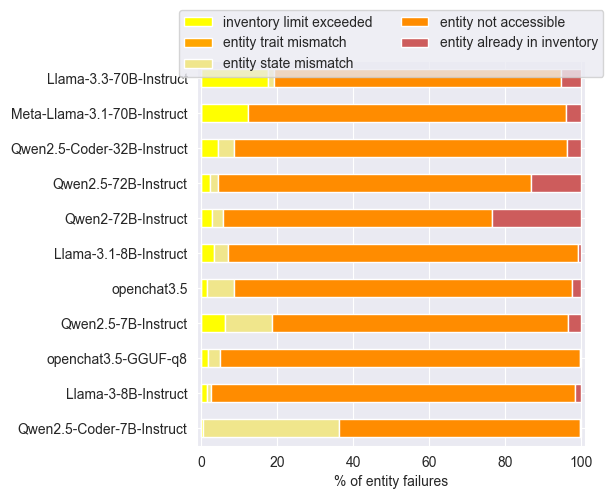

In [211]:
STACK_COLORS = ['yellow', 'orange', 'red', 'khaki', 'darkorange', 'indianred']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [212]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean  \
game          model               metric                               
adventuregame Llama-3-8B-Instruct Aborted                   0.390625   
                                  Lose                      0.570312   
                                  Main Score               16.666667   
                                  Parsed Request Count     23.757812   
                                  Played                    0.609375   
...                                                              ...   
              openchat3.5-GGUF-q8 undefined_action          0.000000   
                                  undefined_action_verb     0.492188   
                                  undefined_argument_type   0.000000   
                                  undefined_repr_str        0.757812   
                                  world_state_discrepancy   0.000000   

                                                                 std  \
game          model               metric                               
adventuregame Llama-3-8B-Instruct Aborted                   0.489808   
                                  Lose                      0.496977   
                                  Main Score               27.430019   
                                  Parsed Request Count     18.092825   
                                  Played                    0.489808   
...                                                              ...   
              openchat3.5-GGUF-q8 undefined_action          0.000000   
                                  undefined_action_verb     4.081832   
                                  undefined_argument_type   0.000000   
                                  undefined_repr_str        4.258842   
                                  world_state_discrepancy   0.000000   

                                                                  var  median  \
game          model               metric                                        
adventuregame Llama-3-8B-Instruct Aborted                    0.239911     0.0   
                                  Lose                       0.246986     1.0   
                                  Main Score               752.405949     0.0   
                                  Parsed Request Count     327.350332    21.0   
                                  Played                     0.239911     1.0   
...                                                               ...     ...   
              openchat3.5-GGUF-q8 undefined_action           0.000000     0.0   
                                  undefined_action_verb     16.661356     0.0   
                                  undefined_argument_type    0.000000     0.0   
                                  undefined_repr_str        18.137734     0.0   
                                  world_state_discrepancy    0.000000     0.0   

                                                             max  min  \
game          model               metric                                
adventuregame Llama-3-8B-Instruct Aborted                    1.0  0.0   
                                  Lose                       1.0  0.0   
                                  Main Score               100.0  0.0   
                                  Parsed Request Count      50.0  1.0   
                                  Played                     1.0  0.0   
...                                                          ...  ...   
              openchat3.5-GGUF-q8 undefined_action           0.0  0.0   
                                  undefined_action_verb     46.0  0.0   
                                  undefined_argument_type    0.0  0.0   
                                  undefined_repr_str        32.0  0.0   
                                  world_state_discrepancy    0.0  0.0   

                                                                skew  
game          model               metric                              
adventuregame Llama-3-8B-Instruct Aborted   

In [213]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean  \
game          model                       metric                              
adventuregame Llama-3-8B-Instruct         action_parsing_fail      1.140625   
                                          action_resolution_fail   8.335938   
              Llama-3.1-8B-Instruct       action_parsing_fail      5.500000   
                                          action_resolution_fail   9.968750   
              Llama-3.3-70B-Instruct      action_parsing_fail      0.734375   
                                          action_resolution_fail   2.320312   
              Meta-Llama-3.1-70B-Instruct action_parsing_fail      0.496063   
                                          action_resolution_fail   2.629921   
              Qwen2-72B-Instruct          action_parsing_fail      9.757812   
                                          action_resolution_fail   5.312500   
              Qwen2.5-72B-Instruct        action_parsing_fail      5.007812   
                                          action_resolution_fail   6.218750   
              Qwen2.5-7B-Instruct         action_parsing_fail      5.546875   
                                          action_resolution_fail  12.867188   
              Qwen2.5-Coder-32B-Instruct  action_parsing_fail      5.382812   
                                          action_resolution_fail   7.742188   
              Qwen2.5-Coder-7B-Instruct   action_parsing_fail     16.570312   
                                          action_resolution_fail   4.250000   
              openchat3.5                 action_parsing_fail      4.109375   
                                          action_resolution_fail  17.429688   
              openchat3.5-GGUF-q8         action_parsing_fail      2.156250   
                                          action_resolution_fail  17.773438   

                                                                        std  \
game          model                       metric                              
adventuregame Llama-3-8B-Instruct         action_parsing_fail      3.861244   
                                          action_resolution_fail   8.784630   
              Llama-3.1-8B-Instruct       action_parsing_fail     11.746670   
                                          action_resolution_fail   8.174222   
              Llama-3.3-70B-Instruct      action_parsing_fail      1.288864   
                                          action_resolution_fail   2.458902   
              Meta-Llama-3.1-70B-Instruct action_parsing_fail      0.941748   
                                          action_resolution_fail   5.171354   
              Qwen2-72B-Instruct          action_parsing_fail     13.199109   
                                          action_resolution_fail   4.567516   
              Qwen2.5-72B-Instruct        action_parsing_fail      8.373652   
                                          action_resolution_fail   4.994387   
              Qwen2.5-7B-Instruct         action_parsing_fail     10.800889   
                                          action_resolution_fail  11.045626   
              Qwen2.5-Coder-32B-Instruct  action_parsing_fail     12.257809   
                                          action_resolution_fail   6.918247   
              Qwen2.5-Coder-7B-Instruct   action_parsing_fail     21.628096   
                                          action_resolution_fail  10.417278   
              openchat3.5                 action_parsing_fail     11.084667   
                                          action_resolution_fail  16.330101   
              openchat3.5-GGUF-q8         action_parsing_fail      7.944133   
                                          action_resolution_fail  15.200609   

                                                                         var  \
game          model                       metric                               
adventuregame Llama-3-8B-Instruct         action_parsing_fail      14.909203   
                                     

Break results down by experiment:

In [214]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean  \
game          model               experiment             metric                               
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                   0.125000   
                                                         Lose                      0.750000   
                                                         Main Score               33.333333   
                                                         Parsed Request Count     25.250000   
                                                         Played                    0.875000   
...                                                                                     ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action          0.000000   
                                                         undefined_action_verb     0.187500   
                                                         undefined_argument_type   0.000000   
                                                         undefined_repr_str        0.062500   
                                                         world_state_discrepancy   0.000000   

                                                                                        std  \
game          model               experiment             metric                               
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                   0.341565   
                                                         Lose                      0.447214   
                                                         Main Score               40.368671   
                                                         Parsed Request Count     15.403463   
                                                         Played                    0.341565   
...                                                                                     ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action          0.000000   
                                                         undefined_action_verb     0.403113   
                                                         undefined_argument_type   0.000000   
                                                         undefined_repr_str        0.250000   
                                                         world_state_discrepancy   0.000000   

                                                                                          var  \
game          model               experiment             metric                                 
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                     0.116667   
                                                         Lose                        0.200000   
                                                         Main Score               1629.629630   
                                                         Parsed Request Count      237.266667   
                                                         Played                      0.116667   
...                                                                                       ...   
              openchat3.5-GGUF-q8 planning-hard-invlimit undefined_action            0.000000   
                                                         undefined_action_verb       0.162500   
                                                         undefined_argument_type     0.000000   
                                                         undefined_repr_str          0.062500   
                                                         world_state_discrepancy     0.000000   

                                                                                  median  \
game          model               experiment             metric                            
adventuregame Llama-3-8B-Instruct basic-easy             Aborted                     0.0   
                                                         Lose                

In [215]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [216]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [217]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Parsed Request Count,9.0
2,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Count,9.0
3,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
57682,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_5,Played,1.0
57683,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_6,Played,1.0
57684,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_7,Played,1.0
57685,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_8,Played,0.0


In [218]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean                  std  \
metric                                      Played      Score    Played   
model               experiment                                            
Llama-3-8B-Instruct basic-easy              0.8750  33.333333  0.341565   
                    basic-easy-invlimit     1.0000  25.000000  0.000000   
                    basic-hard              1.0000  20.833333  0.000000   
                    basic-hard-invlimit     1.0000  12.500000  0.000000   
                    planning-easy           0.0625  14.583333  0.250000   
...                                            ...        ...       ...   
openchat3.5-GGUF-q8 basic-hard-invlimit     1.0000   6.250000  0.000000   
                    planning-easy           0.9375  20.833333  0.250000   
                    planning-easy-invlimit  1.0000   4.166667  0.000000   
                    planning-hard           0.8125   4.166667  0.403113   
                    planning-hard-invlimit  0.7500   6.250000  0.447214   

                                                       
metric                                          Score  
model               experiment                         
Llama-3-8B-Instruct basic-easy              40.368671  
                    basic-easy-invlimit     39.440532  
                    basic-hard              16.666667  
                    basic-hard-invlimit     16.666667  
                    planning-easy           24.247948  
...                                               ...  
openchat3.5-GGUF-q8 basic-hard-invlimit     13.437096  
                    planning-easy           31.914237  
                    planning-easy-invlimit  16.666667  
                    planning-hard           11.385501  
                    planning-hard-invlimit  13.437096  

[88 rows x 4 columns]

In [219]:
selected_stats_df.to_html("results/selected_stats.html")

In [220]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Planning variant:

In [221]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard", "planning-easy-invlimit", "planning-hard-invlimit"]')
plan_df

,game,model,experiment,episode,metric,value
640,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,Violated Request Count,0.0
641,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,Parsed Request Count,9.0
642,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,Request Count,9.0
643,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,Request Success Ratio,1.0
644,adventuregame,Llama-3.3-70B-Instruct,planning-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
57682,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_5,Played,1.0
57683,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_6,Played,1.0
57684,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_7,Played,1.0
57685,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_8,Played,0.0


In [222]:
selected_plan_df = plan_df.drop(columns=["game"])
selected_plan_df = selected_plan_df.query('metric in ["plan_average_viability_ratio", "plan_followed_ratio", "bad_plan_dismiss_ratio"]')

selected_plan_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_plan_df)
selected_plan_df = selected_plan_df.drop(columns=["var", "median", "max", "min", "skew"])

selected_plan_df = selected_plan_df.rename(metric_name_dict)
selected_plan_df = selected_plan_df.rename({"plan_average_viability_ratio": "Viable", "plan_followed_ratio": "Follow", "bad_plan_dismiss_ratio": "Adapt"})

selected_plan_df = selected_plan_df.reset_index()
selected_plan_df = pd.pivot_table(selected_plan_df, index=['model', 'experiment'], columns='metric')

selected_plan_df

mean            \
metric                                                 Adapt    Follow   
model                       experiment                                   
Llama-3-8B-Instruct         planning-easy           0.923324  0.193796   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.905119  0.232247   
                            planning-hard-invlimit  1.000000  0.000000   
Llama-3.1-8B-Instruct       planning-easy           0.924095  0.269849   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.941071  0.140536   
                            planning-hard-invlimit  1.000000  0.000000   
Llama-3.3-70B-Instruct      planning-easy           0.985656  0.290986   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.976216  0.114092   
                            planning-hard-invlimit  1.000000  0.000000   
Meta-Llama-3.1-70B-Instruct planning-easy           0.951928  0.491672   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.946492  0.239870   
                            planning-hard-invlimit  1.000000  0.000000   
Qwen2-72B-Instruct          planning-easy           0.957515  0.196573   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.974418  0.065113   
                            planning-hard-invlimit  1.000000  0.000000   
Qwen2.5-72B-Instruct        planning-easy           0.938875  0.277250   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.903369  0.234936   
                            planning-hard-invlimit  1.000000  0.000000   
Qwen2.5-7B-Instruct         planning-easy           0.920000  0.222018   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.931317  0.161116   
                            planning-hard-invlimit  1.000000  0.000000   
Qwen2.5-Coder-32B-Instruct  planning-easy           0.925270  0.293679   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.937806  0.156058   
                            planning-hard-invlimit  1.000000  0.000000   
Qwen2.5-Coder-7B-Instruct   planning-easy           1.000000  0.000000   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.986250  0.020000   
                            planning-hard-invlimit  1.000000  0.000000   
openchat3.5                 planning-easy           0.916491  0.120946   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.801202  0.223383   
                            planning-hard-invlimit  1.000000  0.000000   
openchat3.5-GGUF-q8         planning-easy           0.755124  0.310376   
                            planning-easy-invlimit  1.000000  0.000000   
                            planning-hard           0.870417  0.208824   
                            planning-hard-invlimit  1.000000  0.000000   

                                                                   std  \
metric                                                Viable     Adapt   
model                       experiment                                   
Llama-3-8B-Instruct         planning-easy           0.123808  0.084043   
                            planning-easy-invlimit  0.000000  0.000000   
                            planning-hard           0.169288  0.101521   
                            planning-hard-invlimit  0.000000  0.000000   
Llama-3.1-8B-Instruct       planning-easy           0.17701

In [223]:
selected_plan_styled = selected_plan_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_plan_styled.to_latex("results/selected_planning.tex", clines="skip-last;data")

Hallucinations:

In [224]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_0,hallucination_count,0.0
44,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_1,hallucination_count,0.0
84,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_10,hallucination_count,1.0
124,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_11,hallucination_count,0.0
164,adventuregame,Llama-3.3-70B-Instruct,basic-easy,episode_12,hallucination_count,1.0
...,...,...,...,...,...,...
56084,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_5,hallucination_count,0.0
56124,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_6,hallucination_count,0.0
56164,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_7,hallucination_count,0.0
56204,adventuregame,Qwen2.5-Coder-7B-Instruct,planning-hard-invlimit,episode_8,hallucination_count,0.0


In [225]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value


In [226]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:14, [4]]
# hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums['Ratio'] = hallucination_sums.value / 128
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Ratio
model,,
Llama-3-8B-Instruct,47.0,0.367188
Llama-3.1-8B-Instruct,33.0,0.257812
Llama-3.3-70B-Instruct,60.0,0.468750
Meta-Llama-3.1-70B-Instruct,60.0,0.468750
Qwen2-72B-Instruct,32.0,0.250000
Qwen2.5-72B-Instruct,48.0,0.375000
Qwen2.5-7B-Instruct,12.0,0.093750
Qwen2.5-Coder-32B-Instruct,29.0,0.226562
Qwen2.5-Coder-7B-Instruct,4.0,0.031250


In [227]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [228]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Ratio", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [229]:
h_styled = hallucination_sums.style.format(subset="Ratio", precision=3).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [230]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Llama-3-8B-Instruct,0.367188,0.483932,0.234190,0.0,1.0,0.0,0.557601
Llama-3.1-8B-Instruct,0.257812,0.439149,0.192852,0.0,1.0,0.0,1.120493
Llama-3.3-70B-Instruct,0.468750,0.500983,0.250984,0.0,1.0,0.0,0.126735
Meta-Llama-3.1-70B-Instruct,0.472441,0.501217,0.251219,0.0,1.0,0.0,0.111728
Qwen2-72B-Instruct,0.250000,0.434714,0.188976,0.0,1.0,0.0,1.168438
Qwen2.5-72B-Instruct,0.375000,0.486025,0.236220,0.0,1.0,0.0,0.522541
Qwen2.5-7B-Instruct,0.093750,0.292626,0.085630,0.0,1.0,0.0,2.820655
Qwen2.5-Coder-32B-Instruct,0.226562,0.420252,0.176612,0.0,1.0,0.0,1.321958
Qwen2.5-Coder-7B-Instruct,0.031250,0.174676,0.030512,0.0,1.0,0.0,5.452262


## Specific metrics plots
Bar plot overview by model and experiment:

In [248]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(14, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

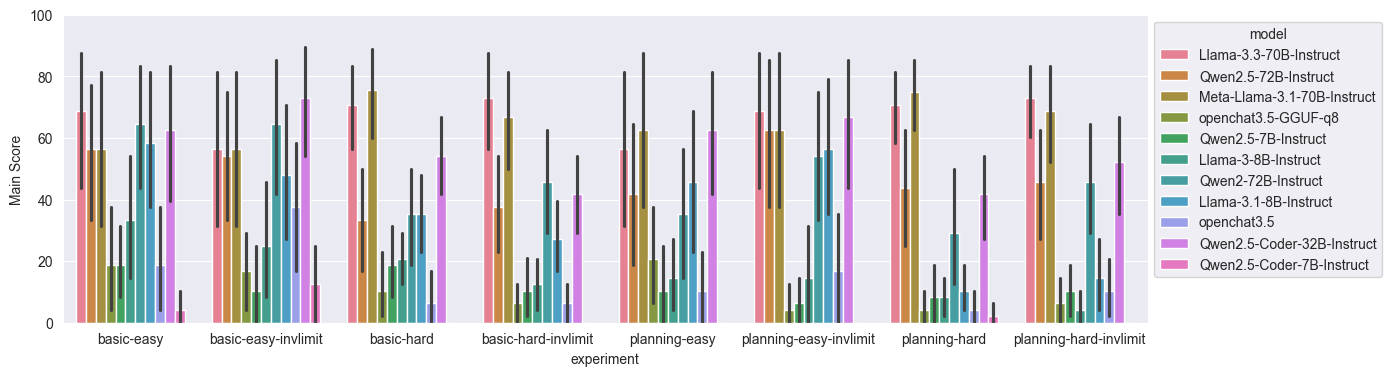

In [249]:
metric_bar_plot(game_df, "Main Score", max_value=100)

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_3404\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


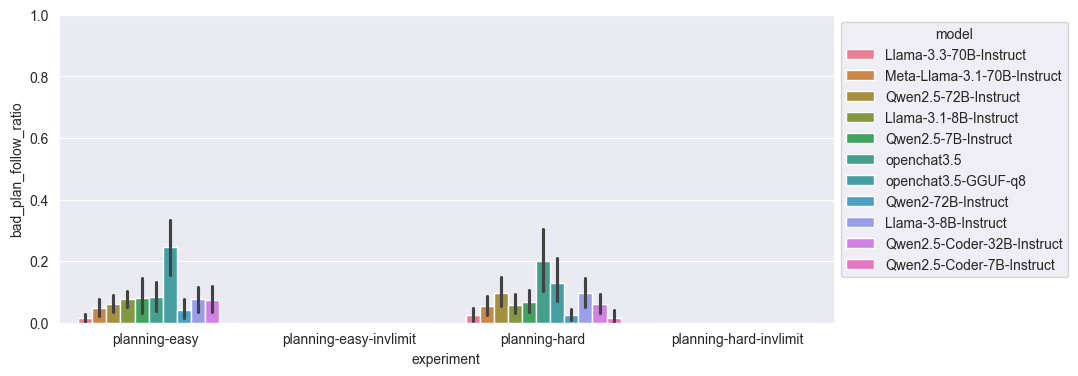

In [233]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_3404\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


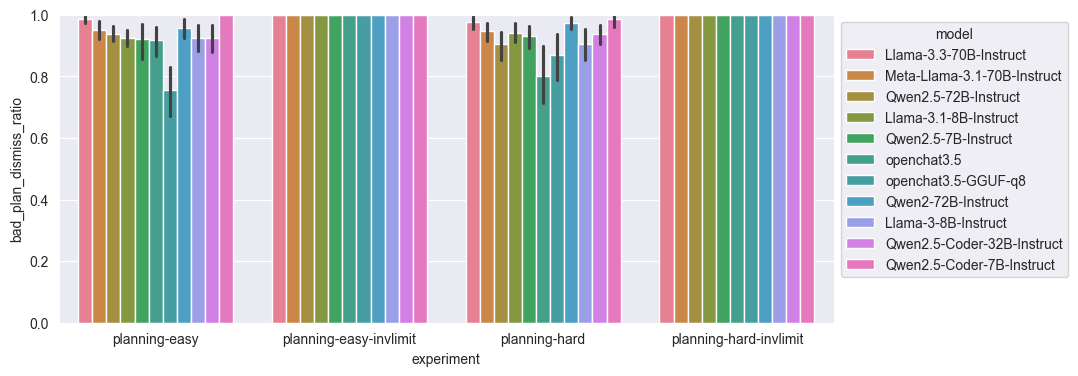

In [234]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_3404\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


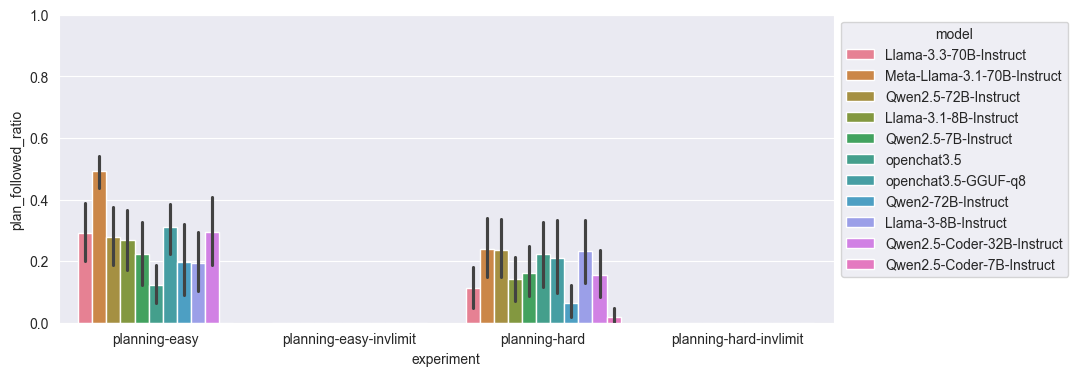

In [235]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_3404\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


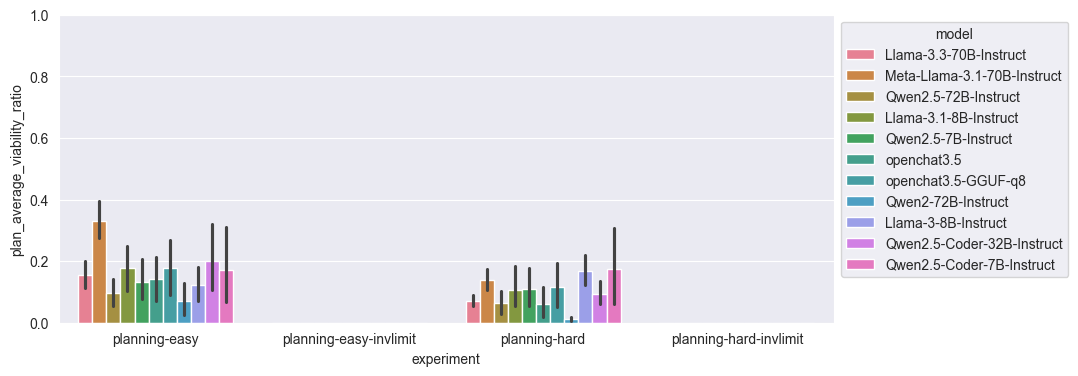

In [236]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")

## Exploration

In [237]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio

[0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

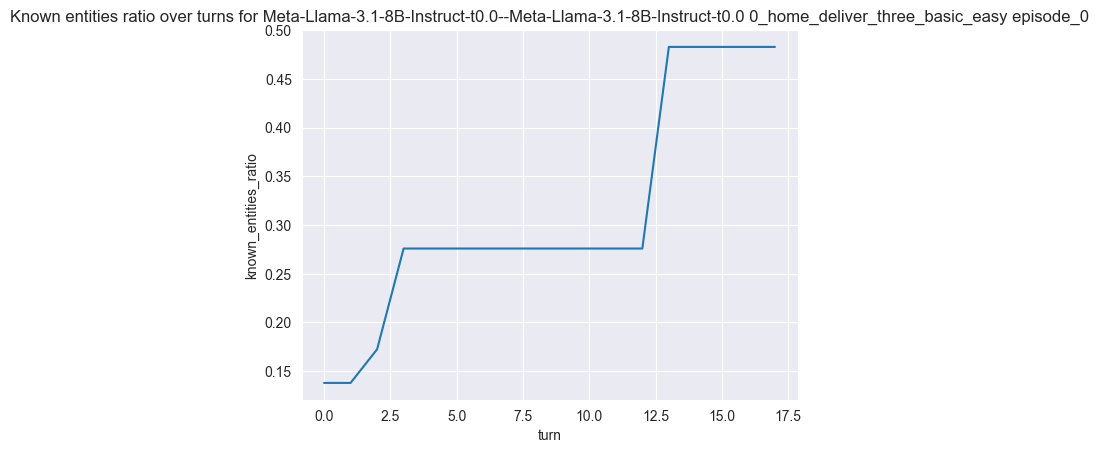

In [238]:
fig, ax = plt.subplots()
ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [250]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_goal_entities_ratio = [score_values['known_goal_entities_ratio'] for score_values in turn_scores.values()]
turns_plan_command_success_ratio

[0.5,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

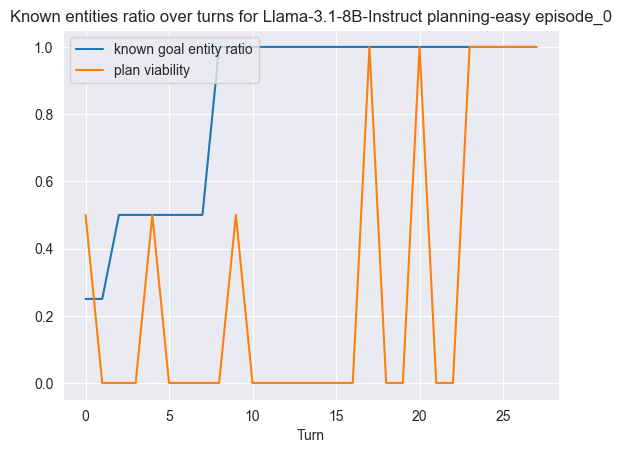

In [260]:
fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_known_goal_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='Turn',
       title=f'Known entities ratio over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['known goal entity ratio', 'plan viability'], loc='upper left')

# fig.savefig("test.png")
plt.show()

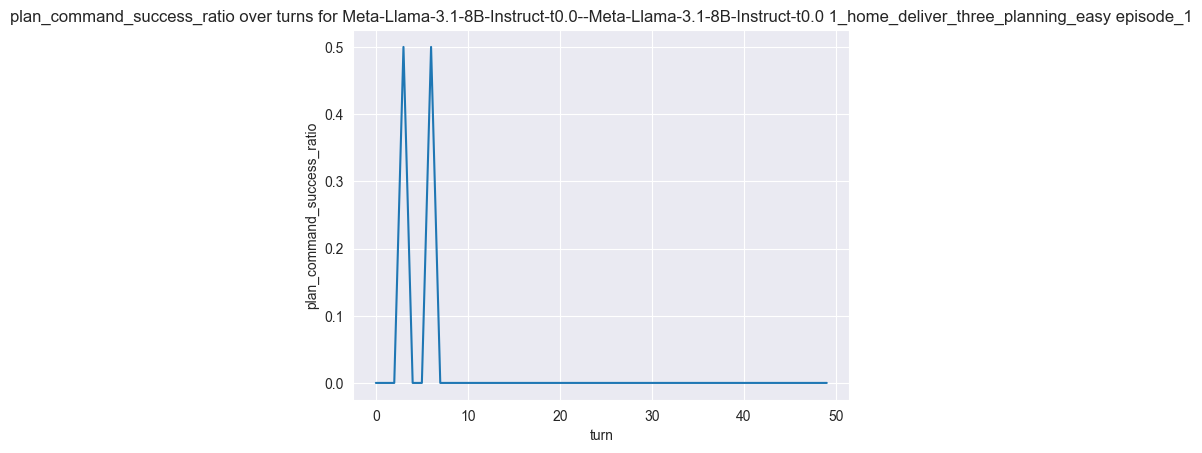

In [241]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "1_home_deliver_three_planning_easy"
episode = "episode_1"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
# turns_plan_command_success_ratio

fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='plan_command_success_ratio',
       title=f'plan_command_success_ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [242]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = [score_values[score] for score_values in turn_scores.values()]
    return turns_score

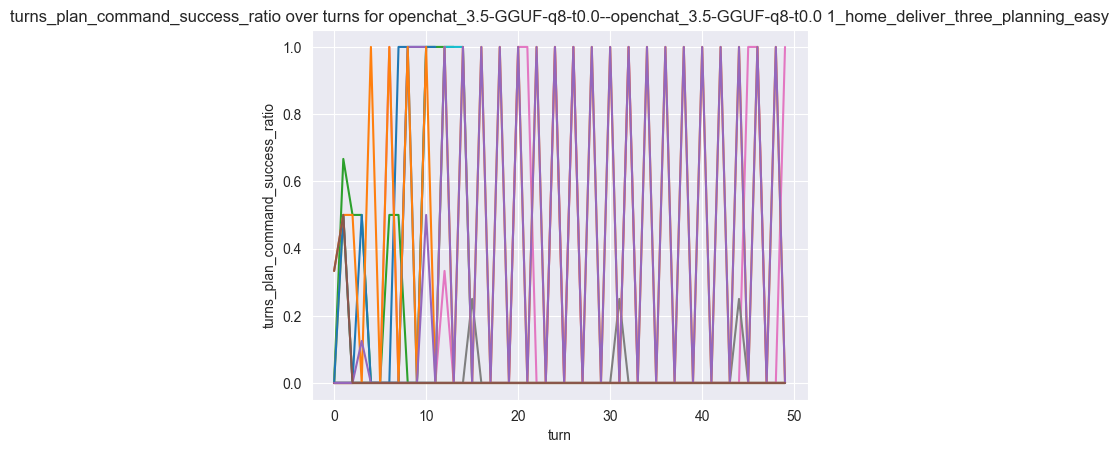

In [243]:
# model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
variant = "1_home_deliver_three_planning_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

fig, ax = plt.subplots()

for episode in episodes:
    turns_plan_command_success_ratio = get_score_progress_list(model_id, variant, episode, "plan_command_success_ratio")
    ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='turn', ylabel='turns_plan_command_success_ratio',
       title=f'turns_plan_command_success_ratio over turns for {model_id} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [244]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

get_exploration_progress_list(model_id, variant, episodes[0], "known_entities_ratio")

[0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

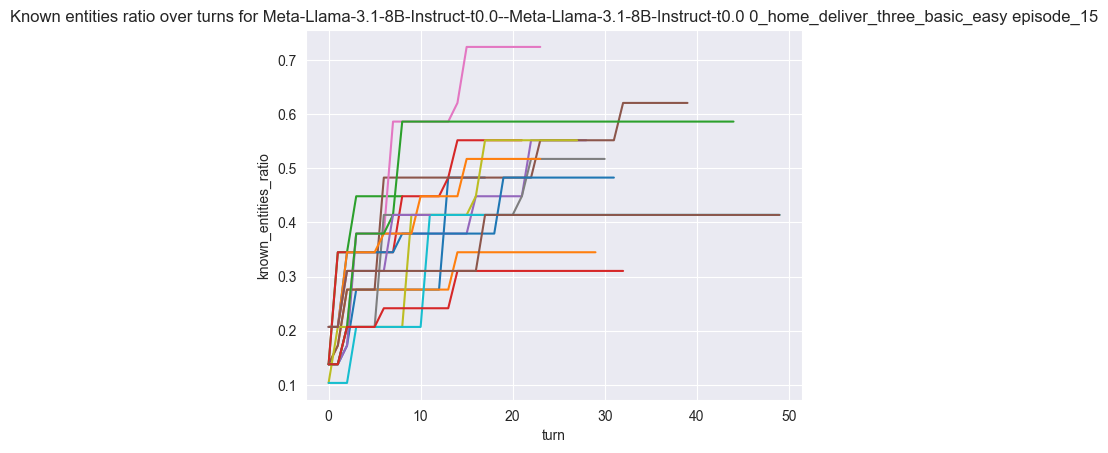

In [245]:
fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, "known_entities_ratio")
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

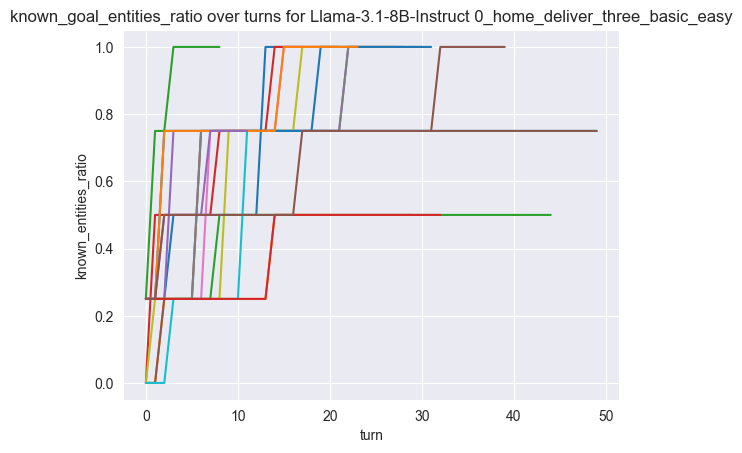

In [246]:
exploration_score = "known_goal_entities_ratio"

fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, exploration_score)
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'{exploration_score} over turns for {model_name_dict[model_id]} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()